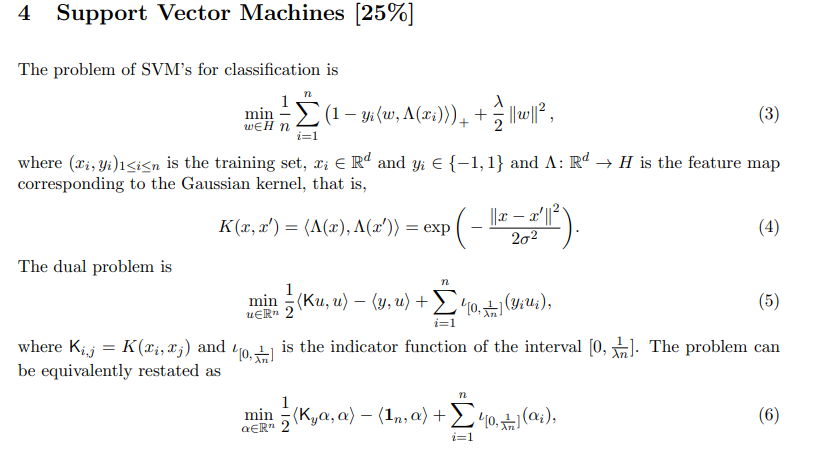
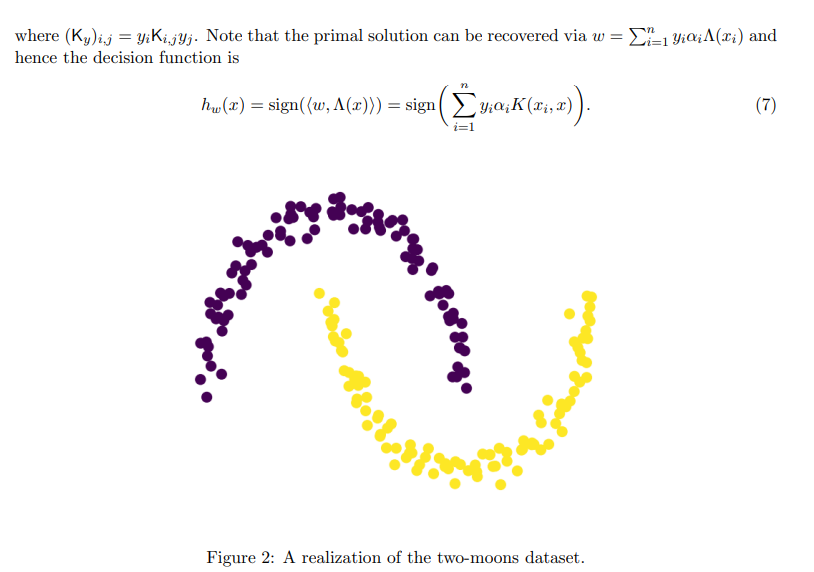
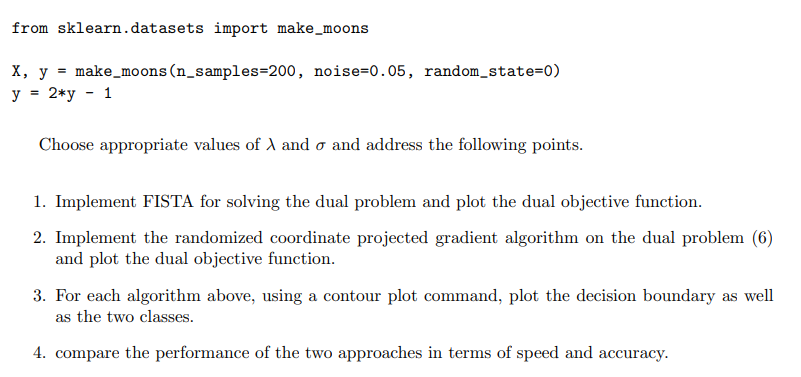

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
import scipy.spatial.distance as cd

In [2]:
X, y = make_moons(n_samples=200, noise=0.05, random_state=0)
y = 2*y - 1
n=200

y = np.expand_dims(y, axis=1)
#chosen values of lam and sigma
lam = 0.01
sigma = 0.4

#computing gaussian kernel gram matrix
K = np.exp((-1.0*cd.cdist(X,X)**2)/(2*(sigma**2)))

#computing dual problem Ky matrix
Ky = y*K*y.T

# FISTA

Let $(t_{k})_{k \in N}$,    $t_{0}=1$,  $t_{k} \geq 1$ and $t_{k}^{2} - t{k} \leq t_{k-1}^{2}$ $\forall k$. 

Let $v_{0} \in X$, $\gamma \leq \frac{1}{L}$ where $f$ is $L$-Lipschitz smooth.

$\alpha_{k+1} = prox_{\gamma g} (v_{k} - \gamma \nabla f(v_{k}))$  

$v_{k+1} = \alpha_{k+1} + \frac{t_{k} - 1}{t_{k+1}} (\alpha_{k+1} - \alpha_{k})$

From the theorem in lectures we know we can either set $t_{k} = \dfrac{1 + \sqrt{1 + 4 t_{k-1}^{2}}}{2}$ or $t_{k} = \dfrac{k+a}{a}$ with $a \geq 2$.

$f(\alpha) = \dfrac{1}{2} \langle K_{y} \alpha, \alpha \rangle - \langle \textbf{1}_{n}, \alpha \rangle = \dfrac{1}{2} \alpha^{T} K_{y}^{T} \alpha + \textbf{1}_{n}^{T} \alpha$

$g(\alpha) = \sum_{i=1}^{n} \iota_{[0, \frac{1}{\lambda n}] (\alpha_{i})}$


$\nabla f(\alpha) = \frac{1}{2} K_{y}^{T} \alpha + \frac{1}{2} K_{y} \alpha$

To find a $L$ note:
$\Vert f(m) - f(l) \Vert = \Vert \frac{1}{2} K_{y}^{T} m + \frac{1}{2} K_{y} m - \frac{1}{2} K_{y}^{T} l - \frac{1}{2} K_{y} l \Vert \\
\leq \frac{1}{2} \Vert  K_{y}^{T} (m-l)\Vert + \frac{1}{2} \Vert  K_{y} (m-l)\Vert$ by triangle inequality

$\leq \Vert K_{y} \Vert \Vert m-l\Vert$ where $\Vert K_{y} \Vert = \Vert K_{y}^{T} \Vert = \sigma_{max} (K_{y}) = L$ is matrix norm induced by euclidean vector norm and $\sigma_{max} (K_{y}) = $ is just largest singular value of $K_{y}$.

Thus we can set $\gamma = \frac{1}{\sigma_{max} (K_{y})}$


Thanks to proposition 5.1.5 in lectures, we can compute the proximity operator componentwise.


In [3]:
#proximity operator for g
def prox(n,lam, t):
    result = t*(t>=0)*(t<=1.0/(lam*n)) + (1/(lam*n))*(t>1.0/(lam*n)) + 0.0*(t<0)
    return result

#gradient of f
def grad(prev_v, Ky):
    result = 0.5*Ky.T@prev_v + 0.5*Ky@prev_v - 1.0
    return result

#one step of FISTA
def FISTA_step(prev_v, prev_alpha, tk_minus_one, gamma, lam, n, Ky):
    t = prev_v - gamma*grad(prev_v, Ky)
    new_alpha = prox(n,lam,t)
    tk = 0.5*(1 + np.sqrt(1 + 4*tk_minus_one**2))
    tk_plus_one = 0.5*(1 + np.sqrt(1 + 4*tk**2))
    new_v = new_alpha + ((tk - 1)/(tk_plus_one))*(new_alpha - prev_alpha)

    return new_v, new_alpha, tk

#objective function for dual
def obj_func(Ky, alpha, lam, n):
    result = 0.5*(Ky@alpha)@alpha - np.sum(alpha) + 10000000*np.sum( (alpha < 0) + (alpha>(1.0/(lam*n))) )
    return result

#classifier
def hw(x, y, X, alpha):
    Kmat = np.exp((-1.0*cd.cdist(X,x)**2)/(2*(sigma**2)))
    result = np.sign(alpha@(y*Kmat))
    return result

In [4]:
#lets find gamma
_,S,_ = np.linalg.svd(Ky)
gamma = 1/S[0]

In [5]:
max_iters = 1000
prev_v = np.random.rand(n) #intial v0
prev_alpha = np.random.rand(n) #intial alpha0
tk_minus_one = 1 #initial t0

obj_vals_FISTA = np.empty(max_iters)

for k in range(1, max_iters+1):
    prev_v, prev_alpha, tk_minus_one = FISTA_step(prev_v, prev_alpha, tk_minus_one, gamma, lam, n, Ky)

    obj_vals_FISTA[k-1] = obj_func(Ky, prev_alpha, lam, n)

final_alpha_FISTA = prev_alpha

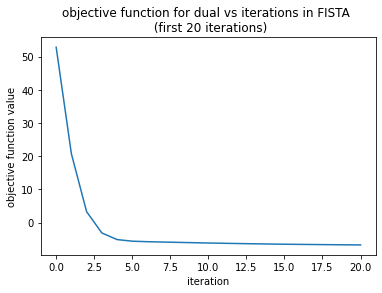

In [6]:
plt.plot(obj_vals_FISTA[:21])
plt.xlabel('iteration')
plt.ylabel('objective function value')
plt.title('objective function for dual vs iterations in FISTA \n (first 20 iterations)')
plt.show()

# randomized block-coordinate proximal-gradient
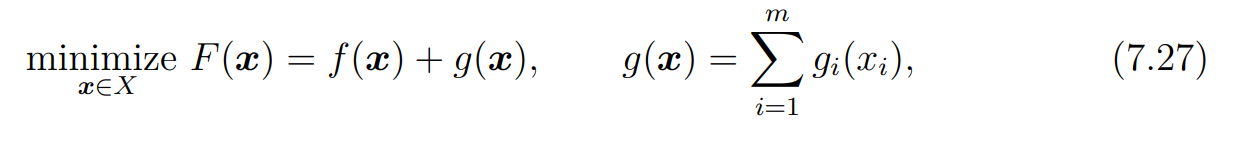
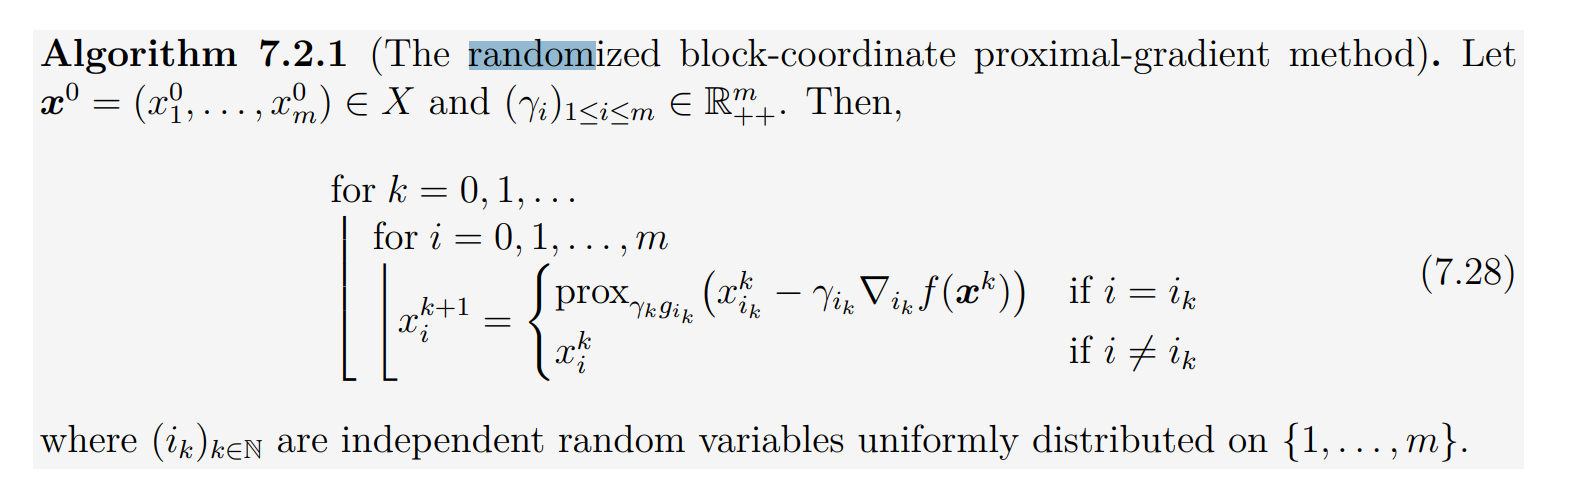
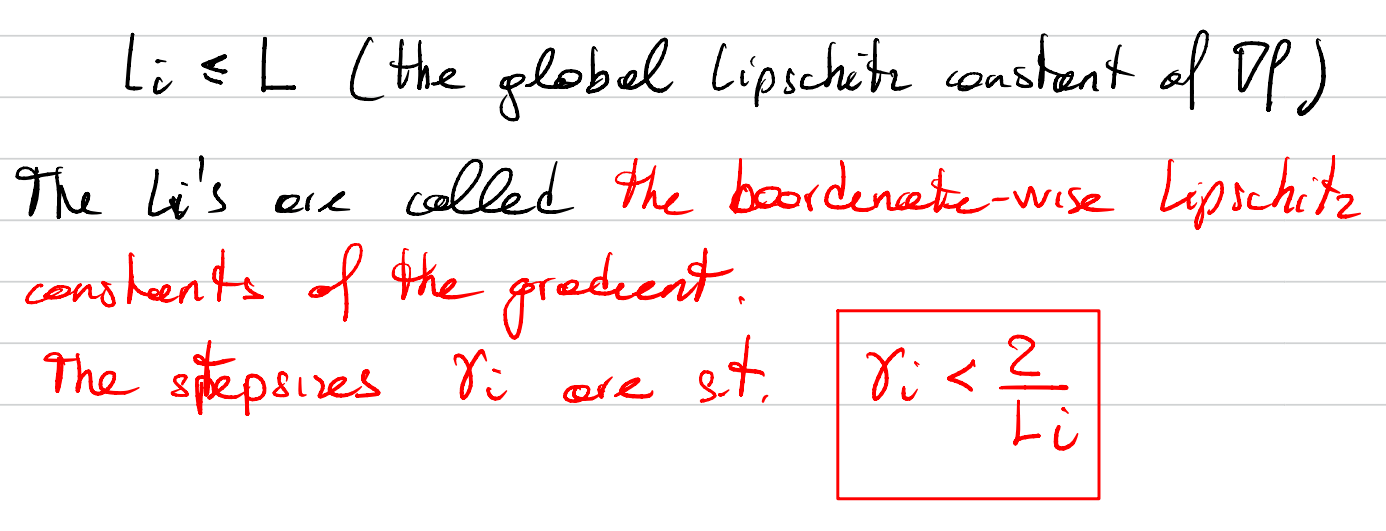

Noting $L_{i} \leq L$ implies $\frac{2}{L_{i}} \geq \frac{2}{L} \geq \frac{1}{L}$ we set each $\gamma_{i} = \frac{1}{L} =\gamma$ where $L$ remains the same as before.

Rewriting $K_{y}^{T} = M$

$f(\alpha) = \dfrac{1}{2} \langle K_{y} \alpha, \alpha \rangle - \langle \textbf{1}_{n}, \alpha \rangle = \dfrac{1}{2} \alpha^{T} M \alpha + \textbf{1}_{n}^{T} \alpha = \sum_{i,j} \alpha_{i} M_{i,j} \alpha_{j} + \sum_{i} \alpha_{i}$

so $\nabla_{i_{k}} f(\alpha) = M_{i_{k},i_{k}} \alpha_{i_{k}} + \sum_{i_{k},j}  M_{i,j}\alpha_{j} + 1$

In [7]:
#gradient with respect to singlem coordinate
def single_component_grad(prev_alpha, Ky, ik):
    M = Ky.T
    result = M[ik-1,ik-1]*prev_alpha[ik-1] + M[ik-1,:]@prev_alpha - 1.0
    return result


def randomised_proximal_gradient(prev_alpha,gamma, lam, n, Ky):
    ik = np.random.randint(1, high=n+1)#random dimension chosen
    t = prev_alpha[ik-1] - gamma*single_component_grad(prev_alpha, Ky, ik)
    update = prox(n,lam,t)

    return update, ik


In [8]:
max_iters = 1000
prev_alpha = np.random.rand(n) #intial alpha0

obj_vals_randomised_proximal= np.empty(max_iters)

for k in range(1, max_iters+1):
    update, ik = randomised_proximal_gradient(prev_alpha,gamma, lam, n, Ky)
    prev_alpha[ik-1] = update
    obj_vals_randomised_proximal[k-1] = obj_func(Ky, prev_alpha, lam, n)

final_alpha_RCPGA = prev_alpha

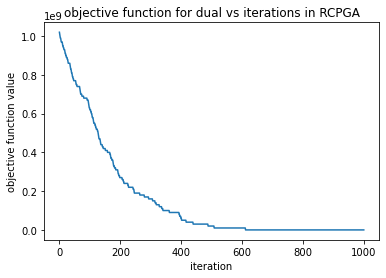

In [9]:
plt.plot(obj_vals_randomised_proximal)
plt.xlabel('iteration')
plt.ylabel('objective function value')
plt.title('objective function for dual vs iterations in RCPGA')
plt.show()

3. For each algorithm above, using a contour plot command, plot the decision boundary as well
as the two classes.

In [10]:
first_group = X[y[:,0] == -1]
second_group = X[y[:,0] == 1]

grid_steps=600
# Creating 2-D grid
[xa, xb] = np.meshgrid(np.linspace(-1.5, 2.5, grid_steps), np.linspace(-1.0, 2.0, grid_steps)) 
xcoords_together = np.stack((xa,xb), axis=2)
labels_FISTA= xa.copy()
labels_RCPGA= xa.copy()
for i in range(grid_steps):
    for j in range(grid_steps):
        xx = np.array([xcoords_together[i,j,:]])
        labels_FISTA[i,j] = hw(xx, y, X, final_alpha_FISTA)[0]
        labels_RCPGA[i,j] = hw(xx, y, X, final_alpha_RCPGA)[0]


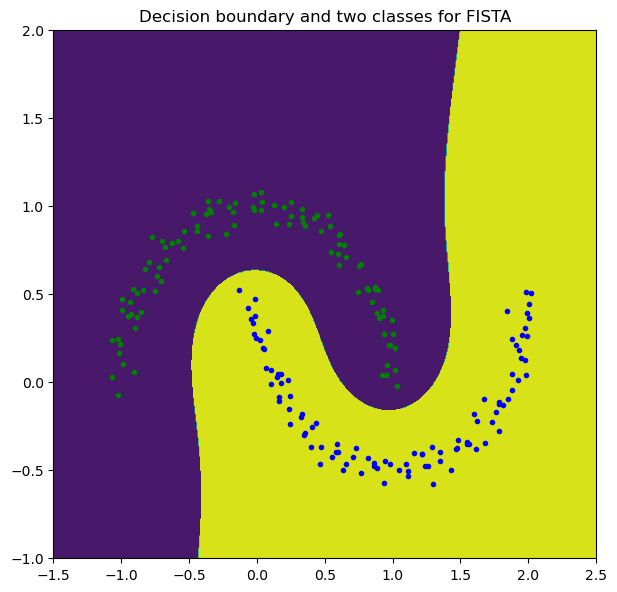

In [11]:
plt.figure(figsize=(7,7), dpi=100)
plt.plot(first_group[:,0], first_group[:,1], '.g')
plt.plot(second_group[:,0], second_group[:,1], '.b')
plt.contourf(xa,xb,labels_FISTA)
plt.title('Decision boundary and two classes for FISTA')
plt.show()

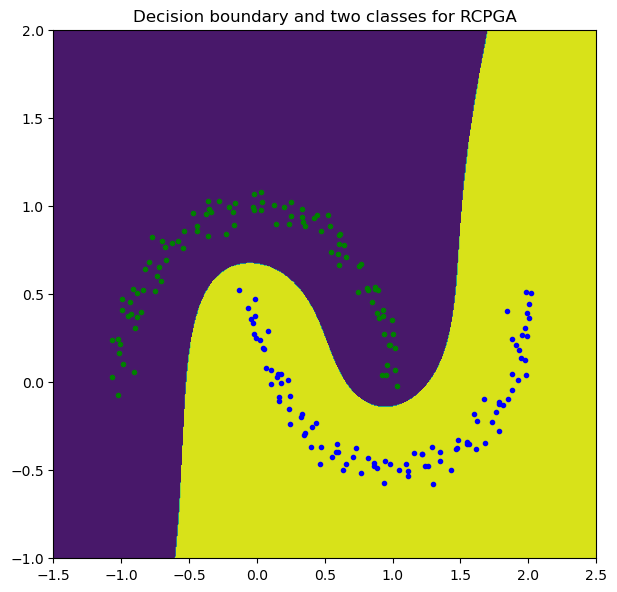

In [12]:
plt.figure(figsize=(7,7), dpi=100)
plt.plot(first_group[:,0], first_group[:,1], '.g')
plt.plot(second_group[:,0], second_group[:,1], '.b')
plt.contourf(xa,xb,labels_RCPGA)
plt.title('Decision boundary and two classes for RCPGA')
plt.show()

4. compare the performance of the two approaches in terms of speed and accuracy

In [13]:
X_test, y_test = make_moons(n_samples=1000, noise=0.05, random_state=0) #testing set
y_test = 2*y_test - 1
y_test = np.expand_dims(y_test, axis=1)

In [14]:
FISTA_train_acc = 100*np.mean(hw(X, y, X, final_alpha_FISTA) == 1.0*y[:,0])
RCPGA_train_acc = 100*np.mean(hw(X, y, X, final_alpha_RCPGA) == 1.0*y[:,0])

FISTA_test_acc = 100*np.mean(hw(X_test, y, X, final_alpha_FISTA) == 1.0*y_test[:,0])
RCPGA_test_acc = 100*np.mean(hw(X_test, y, X, final_alpha_RCPGA) == 1.0*y_test[:,0])

print('FISTA training accuracy: ' + str(FISTA_train_acc))
print('FISTA testing accuracy: ' + str(FISTA_test_acc))
print('RCPGA training accuracy: ' + str(RCPGA_train_acc))
print('RCPGA testing accuracy: ' + str(RCPGA_test_acc))

FISTA training accuracy: 100.0
FISTA testing accuracy: 100.0
RCPGA training accuracy: 100.0
RCPGA testing accuracy: 100.0


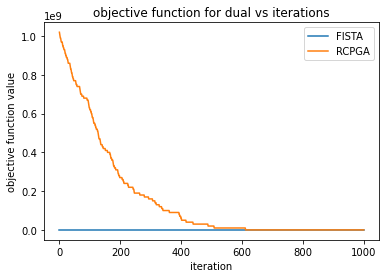

In [15]:
plt.plot(obj_vals_FISTA, label = 'FISTA')
plt.plot(obj_vals_randomised_proximal, label = 'RCPGA')
plt.xlabel('iteration')
plt.ylabel('objective function value')
plt.title('objective function for dual vs iterations')
plt.legend()
plt.show()

$\lambda = 0.01$ and $\sigma = 0.4$ were used.

First we note that the decision boundaries look virtually the same for both algorithms. Second we note that both achieve 100% accuracy on the training set. FISTA achieves 100% accuracy on testing set also, whereas RCPGA gets very close to 100% (but doesn't reach it fully sometimes) accuracy on testing set.Looking at the objective function plots we see that FISTA converges much earlier than RCPGA which makes sense as in RCPGA we only update one of the n-dimensions of $\alpha$ at a time whereas in FISTA we update all of them at every step. Looking at these results, FISTA seems to outperform RCPGA both in speed and accuracy however as we increase n to large magnitudes, we might start seeing some benefits in using the RCPGA especially if we have complicated gradient computations. Lastly, note that RCPGA's objective function plot looks jagged due to its stochastic nature.